# 07wk-1,2: 설명가능한 인공지능 (XAI) – Class Activation Map, CAM

최규빈  
2024-04-15

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/07wk-1-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-wCMWh9t92iWHuMtzrdA3Gv&si=F85VH6sGFIIEmmL_>

# 2. Imports

In [ ]:
import torch
import torchvision
import fastai.vision.all
import matplotlib.pyplot as plt
import requests

# 3. XAI란?

<https://brunch.co.kr/@hvnpoet/140>

# 4. CAM의 구현을 위한 예비학습

## A. DLS

class activation map..

In [ ]:
path = fastai.data.external.untar_data(fastai.data.external.URLs.PETS) #1주차에 하던 것들임..
#path.ls()
(path/'images').ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_150.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_107.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_132.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_133.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_191.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_51.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_115.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_33.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_153.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_171.jpg')...]

In [ ]:
(path/'images').ls()[214],(path/'images').ls()[448],(path/'images').ls()[2976]

(Path('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_98.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_187.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_133.jpg'))

In [ ]:
fnames = fastai.data.transforms.get_image_files(path/'images') #해당 디렉토리에 있는 모든 이미지 파일의 경로가 들어있음..
#fnames = [l for l in (path/'images').ls() if str(l).split('.')[-1] == 'jpg']

In [ ]:
def label_func(fname):
    if fname[0].isupper():
        return 'cat'
    else:
        return 'dog'

In [ ]:
dls = fastai.vision.data.ImageDataLoaders.from_name_func( #대문자인지 소문자인지를 보고 구분하니까.. from_name_func 사용
    path = path/'images', #위는 파일 이름으로 카테고리를 판단하는 함수임.
    fnames = fnames,
    label_func = label_func,
    item_tfms = fastai.vision.augment.Resize(512), #이미지의 사이즈를 통일..
    bs = 32 # batch_size = 32
) #dls 객체..

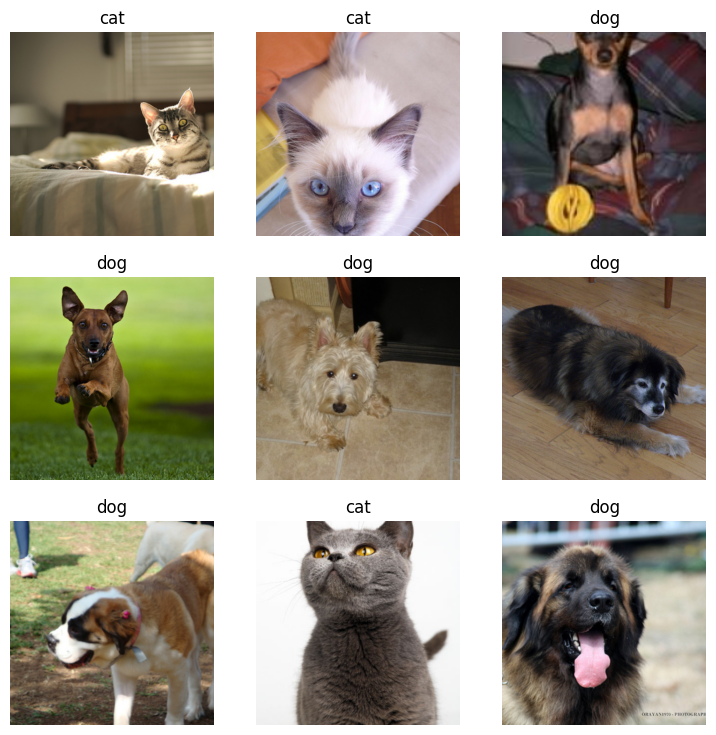

In [ ]:
dls.show_batch() #임의로 몇개의 데이터를 살짝 보기.

## B. 이미지 자료 불러오기

`-` 원래 우리가 아는 방법: path를 의미하는 string $\to$ torch.tensor

In [ ]:
x = torchvision.io.read_image('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_14.jpg') #이미지 자료..
print(f"type: {type(x)}")
print(f"shape: {x.shape}")
print(f"dtype: {x.dtype}")

type: <class 'torch.Tensor'>
shape: torch.Size([3, 333, 500])
dtype: torch.uint8


`-` fastai를 이용하는 방법: path를 의미하는 string $\to$ PILImage $\to$
fastai.torch_core.TensorImage $\to$ torch.tensor

In [ ]:
x_pil = fastai.vision.core.PILImage.create('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_14.jpg') #이거 실행하면 이미지가 보임.
x = next(iter(dls.test_dl([x_pil])))[0] #테스트로 이미지를 만든다는 뜻..이거 실행하면 튜플 나옴.. 길이가 1인 튜플.. [0] 걸면 텐서 이미지 파일이 나옴.
print(f"type: {type(x)}")
print(f"shape: {x.shape}") #512 512로 reshape 되었음.. 옵저베이션을 나타내는 디멘션도 생김.
print(f"dtype: {x.dtype}")
# print('---')
# x = torch.tensor(x)
# print(f"type: {type(x)}")
# print(f"shape: {x.shape}")
# print(f"dtype: {x.dtype}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


type: <class 'fastai.torch_core.TensorImage'>
shape: torch.Size([1, 3, 512, 512])
dtype: torch.float32


In [ ]:
x_pil = fastai.vision.core.PILImage.create(requests.get('https://github.com/guebin/DL2024/blob/main/imgs/01wk-hani1.jpeg?raw=true').content) #웹에 있는 이미지를 바로 불러옴..
x = next(iter(dls.test_dl([x_pil])))[0]
print(f"type: {type(x)}") #얘도 텐서 이미지. dls로 테스트하므로 사이즈도 지정한 512 512로 변경..
print(f"shape: {x.shape}")
print(f"dtype: {x.dtype}")

type: <class 'fastai.torch_core.TensorImage'>
shape: torch.Size([1, 3, 512, 512])
dtype: torch.float32


`-` 참고로 아래와 같이 이미지변환할 수도 있음.

In [ ]:
x_pil = fastai.vision.core.PILImage.create('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_14.jpg')
#x = next(iter(dls.test_dl([x_pil])))[0]
x = fastai.torch_core.TensorImage(x_pil) #dls를 거치지 않았음.
print(f"type: {type(x)}")
print(f"shape: {x.shape}")
print(f"dtype: {x.dtype}")

type: <class 'fastai.torch_core.TensorImage'>
shape: torch.Size([333, 500, 3])
dtype: torch.uint8


## C. 이미지 자료 시각화

이미지가 달라지는 현상 기록... decode 하는 이유... :

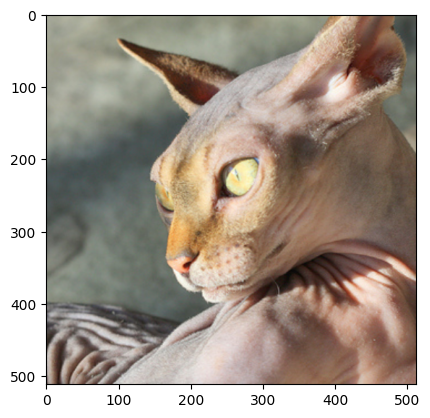

In [ ]:
x_pil = fastai.vision.core.PILImage.create('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_14.jpg')
x = next(iter(dls.test_dl([x_pil])))[0] # lrnr를 학습이후에는 여기에 저장되는 x값이 조금 달라지게됨
x_dec = dls.decode([x])
plt.imshow(torch.einsum('ocij -> ijc', x_dec))

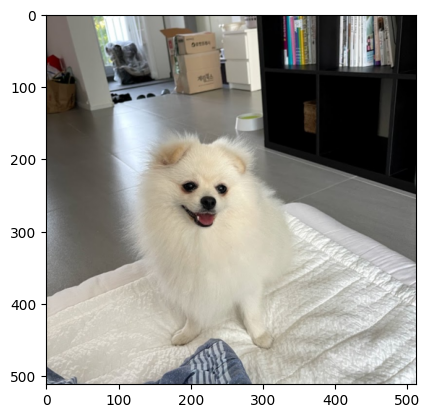

In [ ]:
x_pil = fastai.vision.core.PILImage.create(requests.get('https://github.com/guebin/DL2024/blob/main/imgs/01wk-hani1.jpeg?raw=true').content)
x = next(iter(dls.test_dl([x_pil])))[0] # lrnr를 학습이후에는 여기에 저장되는 x값이 조금 달라지게됨
x_dec = dls.decode([x])
plt.imshow(torch.einsum('ocij -> ijc', x_dec))

## D. AP layer

In [ ]:
ap = torch.nn.AdaptiveAvgPool2d(output_size=1)
ap

AdaptiveAvgPool2d(output_size=1)

In [ ]:
X = torch.arange(1*3*4*4).reshape(1,3,4,4)*1.0
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[16., 17., 18., 19.],
          [20., 21., 22., 23.],
          [24., 25., 26., 27.],
          [28., 29., 30., 31.]],

         [[32., 33., 34., 35.],
          [36., 37., 38., 39.],
          [40., 41., 42., 43.],
          [44., 45., 46., 47.]]]])

In [ ]:
ap(X) # 채널별로 평균을 구해줌.

tensor([[[[ 7.5000]],

         [[23.5000]],

         [[39.5000]]]])

In [ ]:
X[0]

tensor([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]],

        [[16., 17., 18., 19.],
         [20., 21., 22., 23.],
         [24., 25., 26., 27.],
         [28., 29., 30., 31.]],

        [[32., 33., 34., 35.],
         [36., 37., 38., 39.],
         [40., 41., 42., 43.],
         [44., 45., 46., 47.]]])

In [ ]:
#X[:,0,:,:] 이런식으로 한번 인덱스 찍어보는 연습 하기.

In [ ]:
r,g,b = X[0] #언패킹..

In [ ]:
r.mean(), g.mean(), b.mean()

(tensor(7.5000), tensor(23.5000), tensor(39.5000))

In [ ]:
ap(r), ap(g), ap(b)

(tensor([[7.5000]]), tensor([[23.5000]]), tensor([[39.5000]]))

## E. AP, Linear의 교환

`-` 신기한 거 보여줄까요??

In [ ]:
ap(r)*0.1 + ap(g)*0.2 + ap(b)*0.3

tensor([[17.3000]])

In [ ]:
ap(r*0.1 + g*0.2 + b*0.3) #평균을 구하고 실수배를 하거나,,, 실수배를 해서 평균을 구하나,, 같다

tensor([[17.3000]])

-   별로 안 신기함.. 당연한것 아니야?

`-` `torch.nn.Linear()` 와 `torch.nn.Flatten()` 를 이용한 구현

In [ ]:
flatten = torch.nn.Flatten() #1,3,1,1 이 1,3으로 바뀜,
l = torch.nn.Linear(3,1,bias=False) #세값 받아서 한 값으로 반환..

In [ ]:
flatten(ap(X))

tensor([[ 7.5000, 23.5000, 39.5000]])

In [ ]:
# ap(r)*0.1 + ap(g)*0.2 + ap(b)*0.3
l.weight.data = torch.tensor([[0.1, 0.2, 0.3]]) #세 값을 받아서 가중치를 곱해서 평균.
l(flatten(ap(X)))

tensor([[17.3000]], grad_fn=<MmBackward0>)

In [ ]:
#ap(r*0.1 + g*0.2 + b*0.3) ## 각각의 픽셀에 l을 취하고 그 결과에 ap를 취해야함
flatten(ap(torch.einsum('ocij,kc -> okij',X,l.weight.data))) #einsum으로 어떠한 연산을 정의... 이미지의 디멘션과 가중치의 디멘션을 잘 조합한것.. ㅅㅂ
#원래 X는 픽셀이 3개임.. 근데 l의 가중치들을 이용하여 가중합을 구해버려서 하나의 픽셀로 만들고 그 픽셀에 ap를 거는 것

tensor([[17.3000]])

`-` 정리

In [ ]:
# 계산1: x를 ap, flatten, linear 순서로 적용
print(f"{X.shape} -- X")
print(f"{ap(X).shape} -- ap(X)")
print(f"{flatten(ap(X)).shape} -- flatten(ap(X))")
print(f"{l(flatten(ap(X))).shape} -- l(flatten(ap(X)))")

torch.Size([1, 3, 4, 4]) -- X
torch.Size([1, 3, 1, 1]) -- ap(X)
torch.Size([1, 3]) -- flatten(ap(X))
torch.Size([1, 1]) -- l(flatten(ap(X)))


In [ ]:
# 계산2: x를 linear, ap, flatten 순서로 적용
print(f"{X.shape} -- X")
print(f"{torch.einsum('ocij,kc -> okij',X,l.weight.data).shape} -- l(X)") #채널 뻥튀기
print(f"{ap(torch.einsum('ocij,kc -> okij',X,l.weight.data)).shape} -- ap(l(X))")
print(f"{flatten(ap(torch.einsum('ocij,kc -> okij',X,l.weight.data))).shape} -- flatten(ap(l(X)))")

torch.Size([1, 3, 4, 4]) -- X
torch.Size([1, 1, 4, 4]) -- l(X)
torch.Size([1, 1, 1, 1]) -- ap(l(X))
torch.Size([1, 1]) -- flatten(ap(l(X)))


$$\underset{(n,3,4,4)}{\boldsymbol X} \overset{ap}{\to} \underset{(n,3,1,1)}{{\boldsymbol \sharp}}\overset{flatten}{\to} \underset{(n,3)}{{\boldsymbol \sharp}}\overset{linear}{\to} \underset{(n,1)}{\hat{\boldsymbol y}} = [[17.3],...]$$

$$\underset{(n,3,4,4)}{\boldsymbol X} \overset{linear}{\to} \underset{(n,1,4,4)}{{\boldsymbol \sharp}}\overset{ap}{\to} \underset{(n,1,1,1)}{{\boldsymbol \sharp}}\overset{flatten}{\to} \underset{(n,1)}{\hat{\boldsymbol y}} = [[17.3],...]$$

# 5. CAM(Zhou et al. 2016)의 구현

ref: <https://arxiv.org/abs/1512.04150>

`-` 이 강의노트는 위의 논문의 내용을 재구성하였음.

-   논문의 수식을 이해해서 코드로 재구성하는 능력이 새로운 방법을 빠르게
    습득할 수 있도록 해줌.
-   학기 끝나고 “논문-\>코드”로 만드는 과정을 연습하면 대학원등에서
    공부할때 도움이 될 것 같음.

## A. 1단계 – 이미지분류 잘하는 네트워크 선택 후 학습

In [ ]:
lrnr = fastai.vision.learner.vision_learner( #vision learner 는 그냥 기본적으로 CrossEntrophy를 넣어줌
    dls = dls, #사전에 지정한 학습하고자 하는 데이터( + validation dataset)
    arch = fastai.vision.models.resnet34, #정의된 함수 자체를 아키텍쳐로 지정..
    metrics = [fastai.metrics.accuracy] #걍 트랜스퍼 러닝이 짱이라고 한다...
)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 138MB/s]


굳이 실행 안되도 되긴 하는 코드

In [ ]:
lrnr.fine_tune(0) #마지막 부분의 linear 부분만 적합하는 finetune
#fit은 모든 모델의 가중치를 적합함...
#너무 오래걸림.. 걍 앞으로 한번만 하자.

epoch,train_loss,valid_loss,accuracy,time
0,0.131690,0.035476,0.989851,01:53


## B. 2단계– 네트워크의 끝 부분 수정하고 재학습

`-` 일반적으로 CNN계열은 2D-part와 1D-part로 구분되어있음.

flatten 된 이후가 1D-Part

In [ ]:
net1 = lrnr.model[0] # 2d-part 특징을 찾으므로 핵심적 <- 트랜스퍼 러닝은 이걸 유지함
net2 = lrnr.model[1] # 1d-part 정리하는 과정이라고 봄. <- 우리는 이것만 재학습을 하는 것임..

In [ ]:
lrnr.model[1] #미지막에 out_features 가 2임.. 원래 다른 숫자인데 우린 개, 고양이만 식별하면 되므로 바뀐것.
#dls 를 정의를 해두고 finetune을 하니까 알아서 바꿔줬음.. 찌리노!!!

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [ ]:
# 하나의 배치를 테스트용으로 임시로 가져옴
_X, _y = dls.one_batch() #뭐로 구성된건지 궁금하면,, 한번 찍어볼것!
_X.shape,_y.shape

(torch.Size([32, 3, 512, 512]), torch.Size([32]))

In [ ]:
print(f"입력이미지:\t\t {_X.shape}")
print(f"net1통과직후:\t\t {net1(_X).shape}")
print(f"net2의AP까지통과직후:\t {net2[0](net1(_X)).shape}")
print(f"net2의Flatten까지통과직후:\t {net2[1](net2[0](net1(_X))).shape}")
print(f"net2끝까지통과:\t\t {net2(net1(_X)).shape}") #마지막 2는 소프트맥스를 취해서 구한것... 두개를 분류하는데 output이 두개... 비효율적이지만.. 어쩔수 없음

입력이미지:		 torch.Size([32, 3, 512, 512])
net1통과직후:		 torch.Size([32, 512, 16, 16])
net2의AP까지통과직후:	 torch.Size([32, 1024, 1, 1])
net2의Flatten까지통과직후:	 torch.Size([32, 1024])
net2끝까지통과:		 torch.Size([32, 2])


`-` net2를 아래와 같이 수정하자. (왜??) => 기존의 resnet은 해석이 거의 불가능함.. 근데 우리는 net2 부분을 해석이 가능하게 만든 것임...

In [ ]:
net2 = torch.nn.Sequential( #n은 모두 배치사이즈..
    torch.nn.AdaptiveAvgPool2d(output_size=1), # [n, 512, 16, 16] --> [n, 512, 1, 1] #채널별로 평균을 구함.. 1x1이 됨..
    torch.nn.Flatten(), # [n, 512, 1, 1] -->  [n, 512]
    torch.nn.Linear(512,2,bias=False) # [n,512] --> [n,2]
)

In [ ]:
net = torch.nn.Sequential(
    net1, # 원래 resnet34에 있던거..
    net2 # 내가 (CAM을 위해서) 마음대로 바꾼것..
)

In [ ]:
lrnr2 = fastai.learner.Learner(
    dls = dls,
    model = net, #우리가 새로 만둔 network.
    metrics = [fastai.metrics.accuracy] #최규빈 교수님이 코딩 스타일이 바뀌었다 했음.. 그래서 그런거임.. ㅋㅋ
)

In [ ]:
lrnr.loss_func, lrnr2.loss_func # loss_fn 은 따로 정의안했는데 알아서 잘 들어가 있음

(FlattenedLoss of CrossEntropyLoss(), FlattenedLoss of CrossEntropyLoss())

In [ ]:
#lrnr2.fine_tune(5) # net2를 내마음대로 수정했고, 그것에 대한 패널티로 accuracy가 안좋아짐! 그렇지만 그런대로 쓸만함.

## C. 3단계– 수정된 net2에서 Linear와 AP의 순서를 바꿈

`-` 1개의 observation을 고정

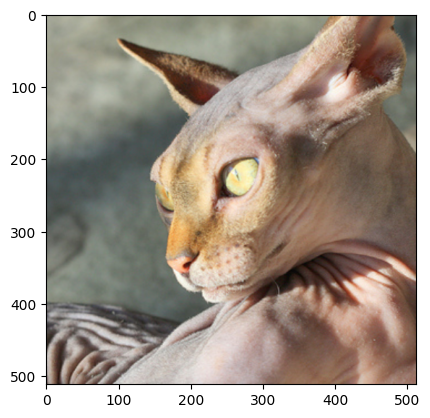

In [ ]:
x_pil = fastai.vision.core.PILImage.create('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_14.jpg')
x = next(iter(dls.test_dl([x_pil])))[0]
x_dec = dls.decode([x])[0] #디코드 하면 정수로 빠짐.. 학습에 변형된 이미지를 복원할 수 있음..
plt.imshow(torch.einsum('ocij -> ijc', x_dec)) #그냥 x로 하면 심령사진 같아짐 ㅋ

`-` 하나의 observation이 yhat까지 나오는 과정

In [ ]:
# 계산방식1: 원래계산방식
ap = lrnr2.model[-1][0] #net2[0]과도 같음. 그냥 한번 생각해보라고 해두신듯.
fl = lrnr2.model[-1][1]
l = lrnr2.model[-1][2]
print(f"{x.shape} -- x")
print(f"{net1(x).shape} -- net1(x)")
print(f"{ap(net1(x)).shape} -- ap(net1(x))")
print(f"{fl(ap(net1(x))).shape} -- flatten(ap(net1(x)))")
print(f"{l(fl(ap(net1(x)))).shape} -- l(flatten(ap(net1(x))))")
l(fl(ap(net1(x)))) #고양이로 분류하겠군,,

torch.Size([1, 3, 512, 512]) -- x
torch.Size([1, 512, 16, 16]) -- net1(x)
torch.Size([1, 512, 1, 1]) -- ap(net1(x))
torch.Size([1, 512]) -- flatten(ap(net1(x)))
torch.Size([1, 2]) -- l(flatten(ap(net1(x))))


TensorImage([[ 2.9390, -2.8556]], device='cuda:0', grad_fn=<AliasBackward0>)

**net2의 순서 바꾸기 전 전체 네트워크**
$$\underset{(1,3,512,512)}{\boldsymbol x} \overset{net_1}{\to} \left( \underset{(1,512,16,16)}{\tilde{\boldsymbol x}} \overset{ap}{\to} \underset{(1,512,1,1)}{{\boldsymbol \sharp}}\overset{flatten}{\to} \underset{(1,512)}{{\boldsymbol \sharp}}\overset{linear}{\to} \underset{(1,2)}{\hat{\boldsymbol y}}\right) = [[2.7846, -2.7945]]$$

In [ ]:
# 계산방식2: net2의 순서를 바꾼 계산, 결국 같아질 것임을 알 수 있다.
ap = lrnr2.model[-1][0]
fl = lrnr2.model[-1][1]
l = lrnr2.model[-1][2]
WHY = torch.einsum('ocij,kc -> okij', net1(x), l.weight.data) #이게 linear임..
print(f"{x.shape} -- x")
print(f"{net1(x).shape} -- net1(x)")
print(f"{WHY.shape} -- l(net1(x)):=WHY")
print(f"{ap(WHY).shape} -- ap(l(net1(x)))=ap(WHY)")
print(f"{fl(ap(WHY)).shape} -- flatten(ap(l(net1(x)))))=flatten(ap(WHY))")
fl(ap(torch.einsum('ocij,kc -> okij', net1(x), l.weight.data)))

torch.Size([1, 3, 512, 512]) -- x
torch.Size([1, 512, 16, 16]) -- net1(x)
torch.Size([1, 2, 16, 16]) -- l(net1(x)):=WHY
torch.Size([1, 2, 1, 1]) -- ap(l(net1(x)))=ap(WHY)
torch.Size([1, 2]) -- flatten(ap(l(net1(x)))))=flatten(ap(WHY))


TensorImage([[ 2.9390, -2.8556]], device='cuda:0', grad_fn=<AliasBackward0>)

**net2의 순서를 바꾼후 전체 네트워크**
$$\underset{(1,3,224,224)}{\boldsymbol x} \overset{net_1}{\to} \left( \underset{(1,512,16,16)}{\tilde{\boldsymbol x}} \overset{linear}{\to} \underset{(1,2,16,16)}{{\bf WHY}}\overset{ap}{\to} \underset{(1,2,1,1)}{{\boldsymbol \sharp}}\overset{flatten}{\to} \underset{(1,2)}{\hat{\boldsymbol y}}\right) = [[2.7846,-2.7945]]$$

-   참고: 여기에서 linear는 (1,512,16,16)의 each pixel에
    `torch.nn.Linear(512,2)`를 수행함.

### $\star$ 잠깐 멈추고 생각 좀 해보자..

`-` 입력이미지

In [ ]:
x_pil, x

(PILImage mode=RGB size=500x333,
 TensorImage([[[[ 0.8104,  0.7933,  0.7762,  ..., -0.6794, -0.6794, -0.6794],
                [ 0.8104,  0.7933,  0.7762,  ..., -0.6965, -0.6965, -0.6965],
                [ 0.8104,  0.7933,  0.7762,  ..., -0.7137, -0.7137, -0.7137],
                ...,
                [-0.6623, -0.2171,  0.3138,  ...,  0.5707,  0.5364,  0.5022],
                [-0.7650, -0.3541,  0.1597,  ...,  0.5707,  0.5193,  0.4851],
                [-0.8335, -0.4568,  0.0398,  ...,  0.5707,  0.5193,  0.4679]],
 
               [[ 0.9930,  0.9755,  0.9580,  ..., -0.5301, -0.5126, -0.4951],
                [ 0.9930,  0.9755,  0.9580,  ..., -0.5301, -0.5126, -0.4951],
                [ 1.0105,  0.9930,  0.9580,  ..., -0.5126, -0.4951, -0.4951],
                ...,
                [-1.0553, -0.5301,  0.1527,  ..., -0.0399,  0.0126,  0.0476],
                [-1.1604, -0.6527,  0.0301,  ...,  0.0301,  0.0651,  0.0651],
                [-1.2479, -0.7402, -0.0574,  ...,  0.0826,  0.08

`-` 원래 net2를 그대로 적용한 결과를 해석

In [ ]:
net2(net1(x)) #적합한 결과~

TensorImage([[ 2.9390, -2.8556]], device='cuda:0', grad_fn=<AliasBackward0>)

-   “2.7846 \> -2.7945” 이므로, `ximg`는 높은 확률로 고양이라는 것을
    의미함.

`-` 바뀐 net2를 적용해볼까?

In [ ]:
WHY.shape #채널 두개.

torch.Size([1, 2, 16, 16])

In [ ]:
ap(WHY).shape #평균내버림

torch.Size([1, 2, 1, 1])

In [ ]:
ap(WHY)

TensorImage([[[[ 2.9390]],

              [[-2.8556]]]], device='cuda:0', grad_fn=<AliasBackward0>)

In [ ]:
flatten(ap(WHY)) #같은 결과..

TensorImage([[ 2.9390, -2.8556]], device='cuda:0', grad_fn=<AliasBackward0>)

In [ ]:
WHY[0,0,:,:].mean() # 이 값이 클수록 고양이, 값도 같다

TensorImage(2.9390, device='cuda:0', grad_fn=<AliasBackward0>)

In [ ]:
WHY[0,1,:,:].mean() # 이 값이 클수록 강아지, 값도 같다 2

TensorImage(-2.8556, device='cuda:0', grad_fn=<AliasBackward0>)

`-` 좀더 파고들어서 분석해보자.

In [ ]:
WHY[0,0,:,:].int() # 이 값들의 평균이 2.7846임. 그리고 이 평균값이 클수록 고양이
#아래의 데이터를 보면... 가운데 부분만 값이 있고, 크다.
#이 평균값이 클수록 고양이라는 것인데.. 평균에 기여하는 부분이 중앙에 몰려있다.
#굳이 int로 보는 이유는 그냥 확인하기 쉬우라고 ㅋㅋ float이 정확한 값임 .

TensorImage([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
             [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -2, -6],
             [ 0,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -2],
             [ 0,  0,  1,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0, -2, -2],
             [ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0],
             [ 0,  0,  0,  0,  0,  0,  2,  3,  3,  4,  2,  1,  0,  0,  0,  0],
             [ 0,  0,  0,  0,  0,  2,  6, 10, 12, 10,  4,  1,  0,  0,  0,  0],
             [ 0,  0,  0,  0,  1,  4, 14, 24, 28, 16,  6,  2,  0,  0,  0,  0],
             [ 0,  0,  0,  0,  2,  8, 21, 34, 33, 21,  7,  3,  0,  0,  0,  0],
             [ 0,  0,  0,  0,  2, 11, 26, 35, 29, 17,  7,  3,  0,  0,  0,  0],
             [ 0,  0,  0,  0,  4, 12, 23, 24, 19, 11,  4,  1,  1,  1,  1,  1],
             [ 0,  0,  0,  1,  6, 12, 18, 12,  7,  4,  2,  1,  0,  0,  1,  0],
             [ 0,  0,  0,  1,  6, 11, 11,  6,  2,  1

-   이 값들의 평균은 2.7846임.
-   이 값들이 클수록 이 그림은 고양이라는 의미임 = 이 값이 작을수록 이
    그림은 고양이 그림이 아니라는 의미임.
-   그런데 살펴보니 대부분의 위치에서 0에 가까운 값을 가지고, 특정
    위치에서만 엄청 큰 값이 있어서 2.7846이라는 값이 나온 것임.
-   특정위치에 존재하는 엄청 큰 값들은, `x`가 고양이 이미지라고 판단하는
    근거가 된다.

In [ ]:
WHY[0,1,:,:].int() # 이 값들의 평균이 2.7846임. 그리고 이 평균값이 클수록 고양이, 작으면 강아지겠지!

TensorImage([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
                0,   0,   0],
             [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
                0,   1,   6],
             [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
                0,   1,   2],
             [  0,   0,   0,   0,   0,   0,   0,   0,  -1,   0,   0,   0,   0,
                0,   2,   2],
             [  0,   0,   0,   0,   0,   0,  -1,  -1,  -1,  -1,  -1,   0,   0,
                0,   0,   0],
             [  0,   0,   0,   0,   0,   0,  -3,  -3,  -3,  -4,  -3,  -1,   0,
                0,   0,   0],
             [  0,   0,   0,   0,   0,  -2,  -6, -10, -12, -10,  -5,  -1,   0,
                0,   0,   0],
             [  0,   0,   0,   0,   0,  -4, -13, -23, -26, -16,  -6,  -2,   0,
                0,   0,   0],
             [  0,   0,   0,   0,  -1,  -8, -20, -33, -32, -20,  -8,  -3,   0,
                0,   0,   0],
             [  0, 

-   특정위치에 존재하는 작은 값들은, 이 그림이 고양이가 아니라고
    판단하는 근거가 된다.

$$\underset{(1,2,16,16)}{{\bf WHY}}\overset{ap}{\to} \underset{(1,2,1,1)}{{\boldsymbol \sharp}}\overset{flatten}{\to} \underset{(1,2)}{\hat{\boldsymbol y}} = [[2.7846,-2.7945]]$$

`-` 시각화1

In [ ]:
WHYCAT = WHY[0,0,:,:].to("cpu").detach() #강의노트랑 좀 다름,,, 우리는 하니 이미지로 진행하였다..
WHYDOG = WHY[0,1,:,:].to("cpu").detach()

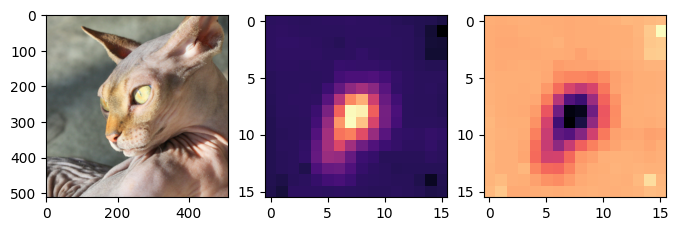

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(8,4))
ax[0].imshow(torch.einsum('ocij -> ijc',x_dec)) #맷플랏립은 채널이 마지막~
ax[1].imshow(WHYCAT,cmap='magma') #마그마맵이란?? -> 검은색 < 보라색 < 빨간색 < 노란색 순으로 숫자가 큼
ax[2].imshow(WHYDOG,cmap='magma') # 가운데 그림의 검정부분 : 고양이가 아니라는 증거, 오른쪽 그림의 밝은 부분: 강아지라는 증거.

-   magma: 검은색 \< 보라색 \< 빨간색 \< 노란색
-   가운데 그림의 노란부분은 고양이라는 증거, 오른쪽 그림의 검보라색
    부분은 고양이가 아니라는 증거

`-` 시각화2

In [ ]:
WHYCAT.shape

torch.Size([16, 16])

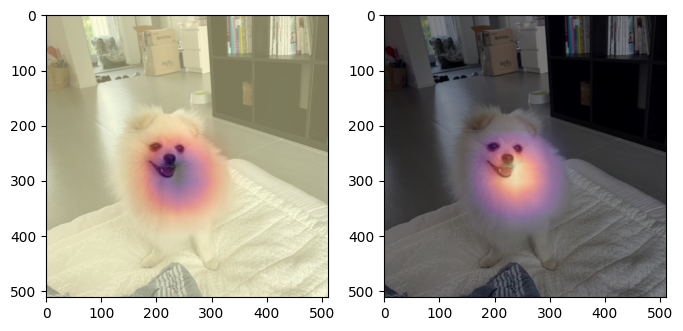

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(torch.einsum('ocij -> ijc',x_dec))
ax[0].imshow(WHYCAT,cmap='magma',extent = (0,511,511,0), interpolation='bilinear',alpha=0.5) #16x16 마그마 맵을 512,512로 픽셀을 맞춤.
ax[1].imshow(torch.einsum('ocij -> ijc',x_dec))
ax[1].imshow(WHYDOG,cmap='magma',extent = (0,511,511,0), interpolation='bilinear',alpha=0.5)

`-` 하니를 활용한 시각화

In [ ]:
x_pil = fastai.vision.core.PILImage.create(requests.get('https://github.com/guebin/DL2024/blob/main/imgs/01wk-hani1.jpeg?raw=true').content)
x = next(iter(dls.test_dl([x_pil])))[0] # lrnr를 학습이후에는 여기에 저장되는 x값이 조금 달라지게됨, #이걸로 WHY를 만들거임..
x_dec = dls.decode([x])
WHY = torch.einsum('ocij,kc -> okij', net1(x), l.weight.data) #학습된 네트워크에 하니를 집어 넣은 것. 일종의 test..
WHYCAT = WHY[0,0,:,:].to("cpu").detach()
WHYDOG = WHY[0,1,:,:].to("cpu").detach()
softmax = torch.nn.Softmax(dim=1)
cat_prob, dog_prob = softmax(flatten(ap(WHY))).to("cpu").detach().tolist()[0]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Text(0.5, 1.0, 'dog prob = 0.999968')

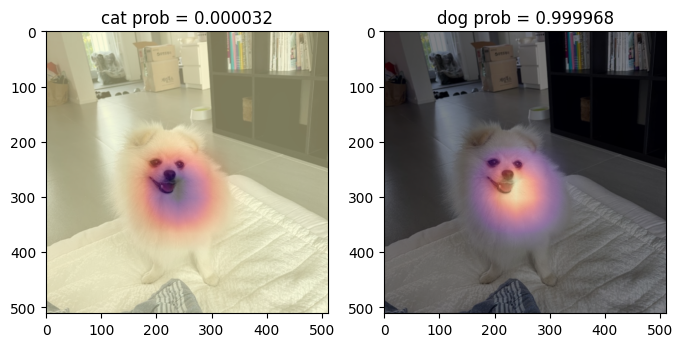

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(torch.einsum('ocij -> ijc',x_dec))
ax[0].imshow(WHYCAT,cmap='magma',extent = (0,511,511,0), interpolation='bilinear',alpha=0.5)
ax[0].set_title(f"cat prob = {cat_prob:.6f}") #어두운 부분... 고양이가 아니라고 생각하는 증거..
ax[1].imshow(torch.einsum('ocij -> ijc',x_dec))
ax[1].imshow(WHYDOG,cmap='magma',extent = (0,511,511,0), interpolation='bilinear',alpha=0.5)
ax[1].set_title(f"dog prob = {dog_prob:.6f}") #밝은 부분... 강아지라고 생각하는 증거.

## D. 4단계 – CAM 시각화

In [ ]:
fig,ax = plt.subplots(5,5)
#---#
k=0
for i in range(5):
    for j in range(5):
        x_pil = fastai.vision.core.PILImage.create(fastai.data.transforms.get_image_files(path/'images')[k])
        x = next(iter(dls.test_dl([x_pil])))[0] # 이걸로 WHY를 만들어보자.
        x_dec = dls.decode([x])[0] # 이걸로 시각화
        WHY = torch.einsum('ocij,kc -> okij',net1(x),l.weight.data)
        WHYCAT = WHY[0,0,:,:].to("cpu").detach()
        WHYDOG = WHY[0,1,:,:].to("cpu").detach()
        cat_prob, dog_prob = softmax(flatten(ap(WHY))).to("cpu").detach().tolist()[0]
        if cat_prob > dog_prob:
            ax[i][j].imshow(torch.einsum('ocij -> ijc',x_dec))
            ax[i][j].imshow(WHYCAT,cmap='magma',extent = (0,511,511,0), interpolation='bilinear',alpha=0.5)
            ax[i][j].set_title(f"cat({cat_prob:.2f})")
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
        else:
            ax[i][j].imshow(torch.einsum('ocij -> ijc',x_dec))
            ax[i][j].imshow(WHYDOG,cmap='magma',extent = (0,511,511,0), interpolation='bilinear',alpha=0.5)
            ax[i][j].set_title(f"dog({dog_prob:.2f})")
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
        k=k+1
fig.set_figheight(16) #후천적?으로 피규어 사이즈를 조정하는 방법... 엄청엄청 유용하다.
fig.set_figwidth(16)
fig.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig,ax = plt.subplots(5,5)
#---#
k=25
for i in range(5):
    for j in range(5):
        x_pil = fastai.vision.core.PILImage.create(fastai.data.transforms.get_image_files(path/'images')[k])
        x = next(iter(dls.test_dl([x_pil])))[0] # 이걸로 WHY를 만들어보자.
        x_dec = dls.decode([x])[0] # 이걸로 시각화
        WHY = torch.einsum('ocij,kc -> okij',net1(x),l.weight.data)
        WHYCAT = WHY[0,0,:,:].to("cpu").detach()
        WHYDOG = WHY[0,1,:,:].to("cpu").detach()
        cat_prob, dog_prob = softmax(flatten(ap(WHY))).to("cpu").detach().tolist()[0]
        if cat_prob > dog_prob:
            ax[i][j].imshow(torch.einsum('ocij -> ijc',x_dec))
            ax[i][j].imshow(WHYCAT,cmap='magma',extent = (0,511,511,0), interpolation='bilinear',alpha=0.5)
            ax[i][j].set_title(f"cat({cat_prob:.2f})")
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
        else:
            ax[i][j].imshow(torch.einsum('ocij -> ijc',x_dec))
            ax[i][j].imshow(WHYDOG,cmap='magma',extent = (0,511,511,0), interpolation='bilinear',alpha=0.5)
            ax[i][j].set_title(f"dog({dog_prob:.2f})")
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
        k=k+1
fig.set_figheight(16)
fig.set_figwidth(16)
fig.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig,ax = plt.subplots(5,5)
#---#
k=50
for i in range(5):
    for j in range(5):
        x_pil = fastai.vision.core.PILImage.create(fastai.data.transforms.get_image_files(path/'images')[k])
        x = next(iter(dls.test_dl([x_pil])))[0] # 이걸로 WHY를 만들어보자.
        x_dec = dls.decode([x])[0] # 이걸로 시각화
        WHY = torch.einsum('ocij,kc -> okij',net1(x),l.weight.data)
        WHYCAT = WHY[0,0,:,:].to("cpu").detach()
        WHYDOG = WHY[0,1,:,:].to("cpu").detach()
        cat_prob, dog_prob = softmax(flatten(ap(WHY))).to("cpu").detach().tolist()[0]
        if cat_prob > dog_prob:
            ax[i][j].imshow(torch.einsum('ocij -> ijc',x_dec))
            ax[i][j].imshow(WHYCAT,cmap='magma',extent = (0,511,511,0), interpolation='bilinear',alpha=0.5)
            ax[i][j].set_title(f"cat({cat_prob:.2f})")
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
        else:
            ax[i][j].imshow(torch.einsum('ocij -> ijc',x_dec))
            ax[i][j].imshow(WHYDOG,cmap='magma',extent = (0,511,511,0), interpolation='bilinear',alpha=0.5)
            ax[i][j].set_title(f"dog({dog_prob:.2f})")
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
        k=k+1
fig.set_figheight(16)
fig.set_figwidth(16)
fig.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig,ax = plt.subplots(5,5)
#---#
k=75
for i in range(5):
    for j in range(5):
        x_pil = fastai.vision.core.PILImage.create(fastai.data.transforms.get_image_files(path/'images')[k])
        x = next(iter(dls.test_dl([x_pil])))[0] # 이걸로 WHY를 만들어보자.
        x_dec = dls.decode([x])[0] # 이걸로 시각화
        WHY = torch.einsum('ocij,kc -> okij',net1(x),l.weight.data)
        WHYCAT = WHY[0,0,:,:].to("cpu").detach()
        WHYDOG = WHY[0,1,:,:].to("cpu").detach()
        cat_prob, dog_prob = softmax(flatten(ap(WHY))).to("cpu").detach().tolist()[0]
        if cat_prob > dog_prob:
            ax[i][j].imshow(torch.einsum('ocij -> ijc',x_dec))
            ax[i][j].imshow(WHYCAT,cmap='magma',extent = (0,511,511,0), interpolation='bilinear',alpha=0.5)
            ax[i][j].set_title(f"cat({cat_prob:.2f})")
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
        else:
            ax[i][j].imshow(torch.einsum('ocij -> ijc',x_dec))
            ax[i][j].imshow(WHYDOG,cmap='magma',extent = (0,511,511,0), interpolation='bilinear',alpha=0.5)
            ax[i][j].set_title(f"dog({dog_prob:.2f})")
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
        k=k+1
fig.set_figheight(16)
fig.set_figwidth(16)
fig.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

Zhou, Bolei, Aditya Khosla, Agata Lapedriza, Aude Oliva, and Antonio
Torralba. 2016. “Learning Deep Features for Discriminative
Localization.” In *Proceedings of the IEEE Conference on Computer Vision
and Pattern Recognition*, 2921–29.